# Import Packages and Dataset

## Packages

In [1]:
!pip install transformers

In [0]:
%tensorflow_version 2.x

In [3]:
import torch
import transformers as tfm # pytorch transformers
from sklearn.linear_model import LogisticRegression

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,hamming_loss

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_train_nostopword_preprocessed.csv'

data_train = pd.read_csv(train_path,sep=";")

In [6]:
data_train.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,- kdg will be kind enough to show you how to l...,0,1,0,0,0,0,0,0,0,0,0,0,kadang will be kind enough to show you how to...
1,Ternyata komunis juga bisa nangis',0,0,0,0,0,0,0,0,0,0,0,0,nyata komunis juga bisa menang
2,USER USER Kenapa harus bom ya? Kek yg benar nu...,0,0,0,0,0,0,0,0,0,0,0,0,user user kenapa harus bom seperti benar tun...
3,USER Sumpaaah kaya kalo abis IAA dilanjut olim...,0,0,0,0,0,0,0,0,0,0,0,0,user sumpah kaya kalau habis iya lanjut olimpi...
4,RT USER USER USER USER USER fungsi media sosia...,1,0,1,0,0,0,0,0,1,1,0,0,rt user user user user user fungsi medium sosi...


In [0]:
test_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_test_nostopword_preprocessed.csv'

data_test = pd.read_csv(test_path,sep=";")

In [8]:
data_test.head()

,Index,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,1,GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO ...,1,1,1,0,0,0,0,0,1,1,0,0,ganteng tapi berengsek buat apa who do you thi...
1,2,Sakit jiwa kali yah..,0,0,0,0,0,0,0,0,0,0,0,0,sakit jiwa kali
2,3,"Does insulting one for being ""Cina"", ""Kafir"", ...",0,1,0,0,0,0,0,0,0,0,0,0,do insult one for be cina kafir make you a goo...
3,4,USER USER Karena partaimu pdip itu bajingan',1,1,0,1,0,0,0,0,1,0,1,0,user user karena partai partai demokrasi indon...
4,5,USER USER Jgn salah itu janji jokowi yg di tun...,1,1,1,0,0,0,0,0,1,1,0,0,user user jangan salah itu janji jokowi di tu...


In [0]:
val_path = '/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Data/data_val_nostopword_preprocessed.csv'

data_val = pd.read_csv(val_path,sep=";")

In [10]:
data_val.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,Tweet_Parsed
0,So much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0,so much berengsek people in the world
1,"So, how can I get my REKBER?? rekening berengsek.",0,1,0,0,0,0,0,0,0,0,0,0,so how can i get my rekening berengsek rekenin...
2,RT USER: dasar bajingan!\xf0\x9f\x98\xa0 URL,0,1,0,0,0,0,0,0,0,0,0,0,rt user dasar bajing url
3,USER Krn cebong tdk akn mengakui pria lajang y...,1,1,0,1,0,0,0,0,1,0,1,0,user karena kecebong tidak akan aku pria lajan...
4,"RT USER: ga ada urusannya, monyet. gua broken ...",1,1,1,0,0,0,0,0,1,1,0,0,rt user tidak ada urus monyet aku break home t...


# Features Target Split

In [0]:
X_train = data_train['Tweet_Parsed']
y_train = data_train.drop(['Tweet','Tweet_Parsed'],axis=1).values

X_val = data_val['Tweet_Parsed']
y_val = data_val.drop(['Tweet','Tweet_Parsed'],axis=1).values

X_test = data_test['Tweet_Parsed']
y_test = data_test.drop(['Tweet','Tweet_Parsed','Index'],axis=1).values

# DistilBert Model

In [0]:
model_class, tokenizer_class, pretrained_weights = (tfm.DistilBertModel, tfm.DistilBertTokenizer, 'distilbert-base-multilingual-cased')

## Load Tokenizer and Model

In [0]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

## Tokenize Train Set, Validation Set, and Test Set

In [0]:
train_sequences = X_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
validation_sequences = X_val.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
test_sequences = X_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [0]:
train_padded = sequence.pad_sequences(train_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
validation_padded = sequence.pad_sequences(validation_sequences, maxlen=100, padding="post", truncating="post")

In [0]:
test_padded = sequence.pad_sequences(test_sequences, maxlen=100, padding="post", truncating="post")

## Change Padded to Tensor and Run Model (Forward Pass)

In [0]:
train_ids = torch.tensor(np.array(train_padded)).to(torch.int64)
train_features = []
batch_size = 200
for batch in tqdm(range(0,len(train_ids),batch_size)):
  with torch.no_grad():
    train_last_hidden_states = model(train_ids[batch:batch+batch_size])
    train_features.append(train_last_hidden_states[0])
# train_features = train_features.numpy()

100%|██████████| 67/67 [17:32<00:00, 15.71s/it]


In [0]:
train_features = np.concatenate(train_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_train_nostop_3d.pkl', 'wb') as f:
  pickle.dump(train_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_train_nostop_3d.pkl', 'wb') as f:
  pickle.dump(y_train, f)

In [0]:
validation_ids = torch.tensor(np.array(validation_padded)).to(torch.int64)
validation_features = []
batch_size = 200
for batch in tqdm(range(0,len(validation_ids),batch_size)):
  with torch.no_grad():
    validation_last_hidden_states = model(validation_ids[batch:batch+batch_size])
    validation_features.append(validation_last_hidden_states[0])

100%|██████████| 8/8 [02:05<00:00, 15.72s/it]


In [0]:
validation_features = np.concatenate(validation_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_validation_nostop_3d.pkl', 'wb') as f:
  pickle.dump(validation_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_validation_nostop_3d.pkl', 'wb') as f:
  pickle.dump(y_val, f)

In [0]:
test_ids = torch.tensor(np.array(test_padded)).to(torch.int64)
test_features = []
batch_size = 200
for batch in tqdm(range(0,len(test_ids),batch_size)):
  with torch.no_grad():
    test_last_hidden_states = model(test_ids[batch:batch+batch_size])
    test_features.append(test_last_hidden_states[0])

100%|██████████| 19/19 [04:54<00:00, 15.52s/it]


In [0]:
test_features = np.concatenate(test_features)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_test_nostop_3d.pkl', 'wb') as f:
  pickle.dump(test_features, f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_test_nostop_3d.pkl', 'wb') as f:
  pickle.dump(y_test, f)

In [0]:
while 1:
  print("",end="")

KeyboardInterrupt: ignored

In [0]:
train_features.shape

(13244, 100, 768)

In [0]:
validation_features.shape

(1472, 100, 768)

In [0]:
test_features.shape

(3680, 100, 768)

# Classification

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_train_nostop_3d.pkl', 'rb') as f:
  train_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_train_nostop_3d.pkl', 'rb') as f:
  y_train = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_validation_nostop_3d.pkl', 'rb') as f:
  validation_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_validation_nostop_3d.pkl', 'rb') as f:
  y_validation = pickle.load(f)

In [0]:
with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_test_nostop_3d.pkl', 'rb') as f:
  test_features = pickle.load(f)

with open('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/DistilBert Data/distilbert_y_test_nostop_3d.pkl', 'rb') as f:
  y_test = pickle.load(f)

## Define Model

In [17]:
model = Sequential()
# Configuring the parameters
model.add(InputLayer((100,768)))
model.add(Conv1D(128,5, activation="relu"))
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 128)           491648    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 500,684
Trainable params: 500,684
Non-trainable params: 0
_________________________________________________________________


## Training Model with Adam Optimizer

In [18]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_features, y_train, 
                    validation_data=(validation_features, y_val),
                    epochs=80, batch_size=32, 
                    verbose=2)

Epoch 1/80
414/414 - 5s - loss: 0.3698 - accuracy: 0.5193 - val_loss: 0.3550 - val_accuracy: 0.4599
Epoch 2/80
414/414 - 4s - loss: 0.3458 - accuracy: 0.5482 - val_loss: 0.3395 - val_accuracy: 0.7262
Epoch 3/80
414/414 - 5s - loss: 0.3370 - accuracy: 0.5464 - val_loss: 0.3390 - val_accuracy: 0.4049
Epoch 4/80
414/414 - 5s - loss: 0.3271 - accuracy: 0.5363 - val_loss: 0.3483 - val_accuracy: 0.6549
Epoch 5/80
414/414 - 5s - loss: 0.3220 - accuracy: 0.5289 - val_loss: 0.3223 - val_accuracy: 0.5285
Epoch 6/80
414/414 - 5s - loss: 0.3179 - accuracy: 0.5242 - val_loss: 0.3286 - val_accuracy: 0.4450
Epoch 7/80
414/414 - 5s - loss: 0.3126 - accuracy: 0.5275 - val_loss: 0.3181 - val_accuracy: 0.5584
Epoch 8/80
414/414 - 5s - loss: 0.3082 - accuracy: 0.5207 - val_loss: 0.3127 - val_accuracy: 0.4728
Epoch 9/80
414/414 - 4s - loss: 0.3035 - accuracy: 0.5126 - val_loss: 0.3196 - val_accuracy: 0.4837
Epoch 10/80
414/414 - 4s - loss: 0.3009 - accuracy: 0.5244 - val_loss: 0.3061 - val_accuracy: 0.6019

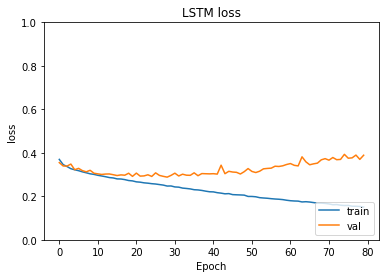

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['train', 'val'], loc='lower right')
plt.show()

## Predict and Result

In [0]:
predict = model.predict(test_features)
predict_train = model.predict(train_features)
predict_val = model.predict(validation_features)
thresholds=0.5

In [0]:
def labelSetAccuracy(y_true, y_pred):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
#         print('\nset_true: {0}'.format(set_true))
#         print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [22]:
pred_test = predict.copy()
pred_test[pred_test>=0.5] = 1
pred_test[pred_test<0.5] = 0
acc = accuracy_score(y_test,pred_test)
haml_loss = hamming_loss(y_test,pred_test)
label_acc = labelSetAccuracy(y_test,pred_test)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")

threshold =  0.5
exact accuracy =  0.48288043478260867
hamming loss =  0.12461503623188405
label based accuracy =  0.612352160973085


In [23]:
pred_train = predict_train.copy()
pred_train[pred_train>=0.5] = 1
pred_train[pred_train<0.5] = 0
acc = accuracy_score(y_train,pred_train)
haml_loss = hamming_loss(y_train,pred_train)
label_acc = labelSetAccuracy(y_train,pred_train)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.6783449109030505
hamming loss =  0.05831571529245948
label based accuracy =  0.7958776780620634


In [24]:
pred_val = predict_val.copy()
pred_val[pred_val>=0.5] = 1
pred_val[pred_val<0.5] = 0
acc = accuracy_score(y_val,pred_val)
haml_loss = hamming_loss(y_val,pred_val)
label_acc = labelSetAccuracy(y_val,pred_val)
print("threshold = ",thresholds)
print("exact accuracy = ", acc)
print("hamming loss = ",haml_loss)
print("label based accuracy = ",label_acc)
print("==============================")


threshold =  0.5
exact accuracy =  0.48777173913043476
hamming loss =  0.12477355072463768
label based accuracy =  0.6217766023982056


## Save Model

In [0]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modeldistilBERT_nostop.h5')

In [0]:
from tensorflow.keras.models import load_model
model = load_model('/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/Model/modeldistilBERT_nostop.h5')

# Analysis Predict

In [0]:
target = data_train.columns[1:-1]

## Data Validation Predict Analysis

In [0]:
data_val = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(y_val,columns=target)).reset_index(drop=True)

In [28]:
data_val.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,1,1,0,1,0,0,0,0,1,0,1,0
1,so how can i get my rekening berengsek rekenin...,0,1,0,0,0,0,0,0,0,0,0,0
2,rt user dasar bajing url,0,1,0,0,0,0,0,0,0,0,0,0
3,user karena kecebong tidak akan aku pria lajan...,1,1,0,1,0,0,0,0,1,0,1,0
4,rt user tidak ada urus monyet aku break home t...,1,1,1,0,0,0,0,0,1,1,0,0


In [0]:
data_val_predict = pd.DataFrame(data=X_val,columns=['Tweet_Parsed']).reset_index(drop=True).join(pd.DataFrame(data=pred_val, columns=target))

In [30]:
data_val_predict.head()

,Tweet_Parsed,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,so much berengsek people in the world,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,so how can i get my rekening berengsek rekenin...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rt user dasar bajing url,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,user karena kecebong tidak akan aku pria lajan...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,rt user tidak ada urus monyet aku break home t...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check Number of Label on Predict Data

In [0]:
label_size0_val = []
label_size1_val = []

for i in data_val.columns[1:]:
    label_size0_val.append(len(data_val[data_val[i]==0]))
    label_size1_val.append(len(data_val[data_val[i]==1]))

label_size0_val_predict = []
label_size1_val_predict = []

for i in data_val_predict.columns[1:]:
    label_size0_val_predict.append(len(data_val_predict[data_val_predict[i]==0]))
    label_size1_val_predict.append(len(data_val_predict[data_val_predict[i]==1]))

In [0]:
dat_anls_val = pd.DataFrame({
    'label' : data_val.columns[1:],
    'stats' : ["negative" for i in range(len(data_val.columns[1:]))],
    'jumlah' : label_size0_val
}).append(
    pd.DataFrame({
        'label' : data_val.columns[1:],
        'stats' : ["positive" for i in range(len(data_val.columns[1:]))],
        'jumlah' : label_size1_val
    })
)

# dat_anls_val = dat_anls_val.set_index(['label'], drop=True)

dat_anls_val_predict = pd.DataFrame({
    'label' : data_val_predict.columns[1:],
    'stats' : ["negative" for i in range(len(data_val_predict.columns[1:]))],
    'jumlah' : label_size0_val_predict
}).append(
    pd.DataFrame({
        'label' : data_val_predict.columns[1:],
        'stats' : ["positive" for i in range(len(data_val_predict.columns[1:]))],
        'jumlah' : label_size1_val_predict
    })
)

# dat_anls_val_predict = dat_anls_val_predict.set_index(['label'], drop=True)

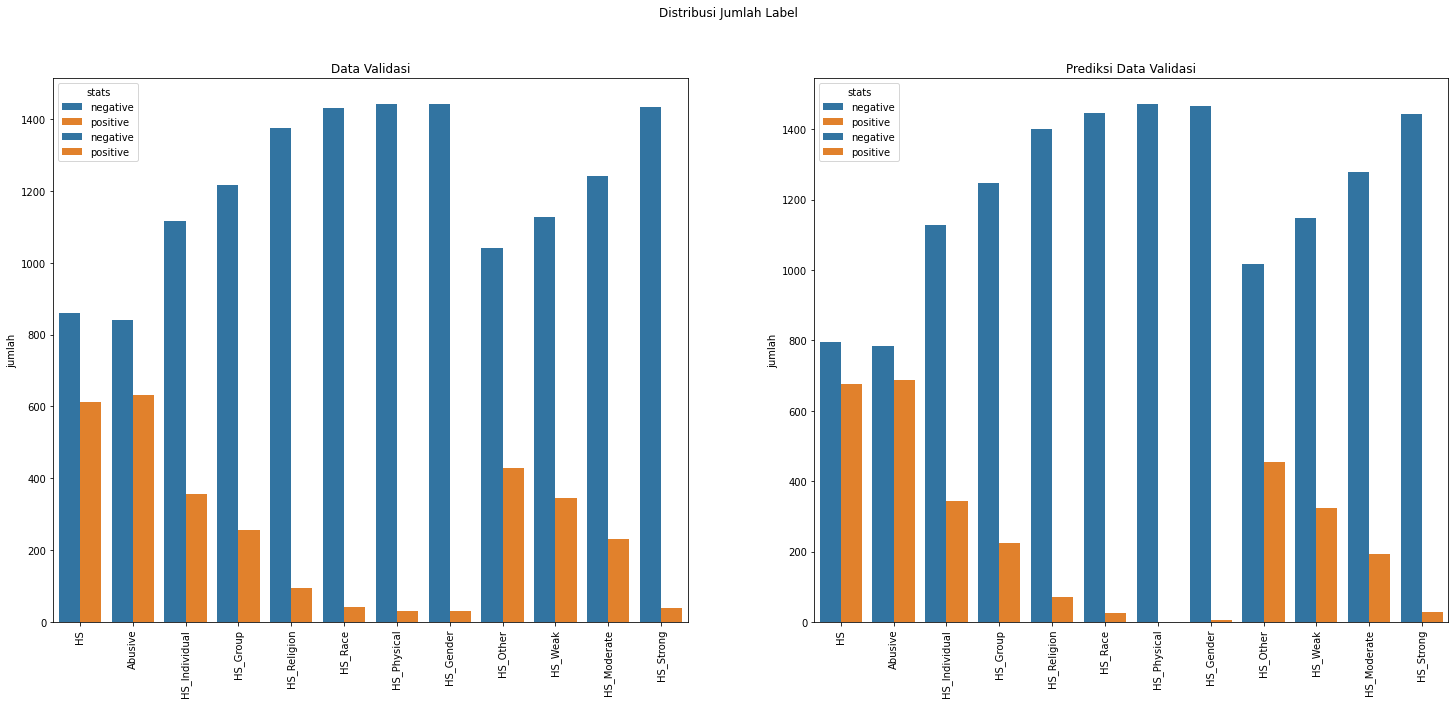

In [33]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val).get_xticklabels(),rotation=90)
plt.title("Data Validasi")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_val_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Validasi")
plt.xlabel('')

plt.show()

In [34]:
pd.DataFrame({
    "label" : data_val.columns[1:],
    "negative (true)" : dat_anls_val[dat_anls_val['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_val[dat_anls_val['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_val_predict[dat_anls_val_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,859,613,796,676
1,Abusive,840,632,784,688
2,HS_Individual,1115,357,1128,344
3,HS_Group,1216,256,1248,224
4,HS_Religion,1376,96,1402,70
5,HS_Race,1431,41,1445,27
6,HS_Physical,1441,31,1471,1
7,HS_Gender,1441,31,1467,5
8,HS_Other,1042,430,1016,456
9,HS_Weak,1128,344,1147,325


### OOV Check

In [0]:
def generate_ngrams(s):
    
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.str.split(" ") if token != ""]
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = np.concatenate(tokens)
    return ngrams

def oov(fitur,token):
    outOfVocab = []
    for i in token:
        if i not in fitur:
            outOfVocab.append(i)
    return outOfVocab

def oov_count(oovList):
    oovCount = {}
    for i in oovList:
        if i in oovCount.keys():
            oovCount[i] = oovCount[i]+1
        else:
            oovCount[i] = 1
    return oovCount

In [0]:
join_data_val = data_val.join(data_val_predict.drop(['Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_val = join_data_val[(join_data_val["HS"]!=join_data_val["HS_predict"]) | (join_data_val["Abusive"] != join_data_val["Abusive_predict"]) | (join_data_val["HS_Individual"] != join_data_val["HS_Individual_predict"]) | (join_data_val["HS_Group"] != join_data_val["HS_Group_predict"]) | (join_data_val["HS_Religion"] != join_data_val["HS_Religion_predict"]) | (join_data_val["HS_Race"] != join_data_val["HS_Race"]) | (join_data_val["HS_Physical"] != join_data_val["HS_Physical_predict"]) | (join_data_val["HS_Gender"] != join_data_val["HS_Gender_predict"]) | (join_data_val["HS_Other"] != join_data_val["HS_Other_predict"]) | (join_data_val["HS_Weak_predict"] != join_data_val["HS_Weak_predict"]) | (join_data_val["HS_Moderate_predict"] != join_data_val["HS_Moderate_predict"]) | (join_data_val["HS_Strong_predict"] != join_data_val["HS_Strong_predict"])]

In [0]:
vocab = tokenizer.ids_to_tokens.values()

In [39]:
tokenizer.ids_to_tokens.values()

odict_values(['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[unused31]', '[unused32]', '[unused33]', '[unused34]', '[unused35]', '[unused36]', '[unused37]', '[unused38]', '[unused39]', '[unused40]', '[unused41]', '[unused42]', '[unused43]', '[unused44]', '[unused45]', '[unused46]', '[unused47]', '[unused48]', '[unused49]', '[unused50]', '[unused51]', '[unused52]', '[unused53]', '[unused54]', '[unused55]', '[unused56]', '[unused57]', '[unused58]', '[unused59]', '[unused60]', '[unused61]', '[unused62]', '[unused63]', '[unused64]', '[unused65]', '[unused66]', '[unused67]', '[unused68]', '[unused69]', '[unused70]', '[unus

In [0]:
oov_val = oov(vocab, generate_ngrams(miss_exact_tweet_val['Tweet_Parsed']))
oov_val_count = oov_count(oov_val)

In [41]:
oov_val_count

{'berengsek': 14,
 'rt': 36,
 'bajing': 11,
 'urus': 5,
 'monyet': 11,
 '': 1076,
 'ampun': 4,
 'rupiah': 7,
 'banget': 21,
 'celeng': 2,
 'buat': 37,
 'synna': 1,
 'emosi': 1,
 'jangan': 27,
 'mancing': 1,
 'malaysia': 63,
 'infinit': 1,
 'tunggu': 5,
 'timnas': 4,
 'shame': 43,
 'bacot': 8,
 'kalian': 19,
 'bahas': 4,
 'rusak': 5,
 'revitalisasi': 1,
 'didik': 3,
 'kafir': 36,
 'banci': 16,
 'sedih': 1,
 'cong': 3,
 'kayak': 11,
 'baca': 9,
 'hadis': 1,
 'syariat': 4,
 'puasa': 2,
 'asyura': 1,
 'akikah': 1,
 'ittiba': 2,
 'ajar': 9,
 'yahudi': 14,
 'sahabat': 4,
 'sunnah': 1,
 'nabi': 5,
 'gamis': 1,
 'mubah': 1,
 'sarung': 1,
 'peci': 2,
 'sendu': 1,
 'gila': 20,
 'maksud': 3,
 'kucing': 2,
 'joke': 4,
 'laugh': 2,
 'pilih': 33,
 'mend': 5,
 'bapak': 7,
 'latih': 2,
 'bosan': 1,
 'monoton': 1,
 'jual': 3,
 'citra': 3,
 'pasang': 3,
 'wajah': 4,
 'melas': 1,
 'anjir': 7,
 'sangka': 1,
 'kemarin': 7,
 'sarap': 3,
 'memang': 35,
 'melulu': 2,
 'kalau': 77,
 'bangsat': 29,
 'expect': 3

In [42]:
print("number of OOV words : ", len(oov_val))
print("number of unique OOV words : ", len(oov_val_count))

number of OOV words :  5844
number of unique OOV words :  1786


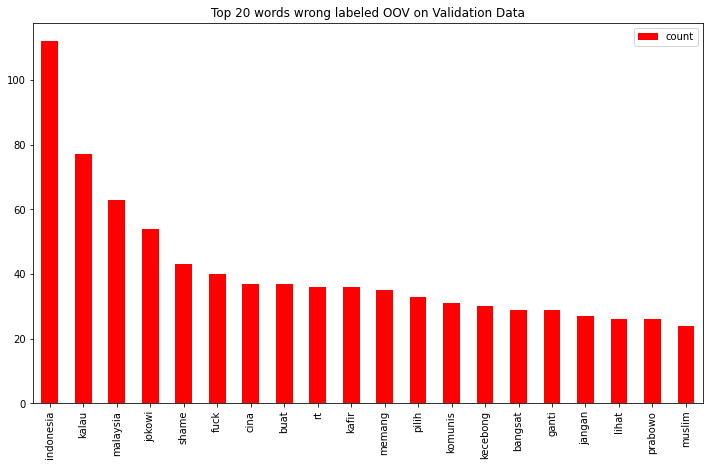

In [43]:
df_oov_val = pd.DataFrame(oov_val_count.items(),columns=["Tweet","count"])
df_oov_val.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

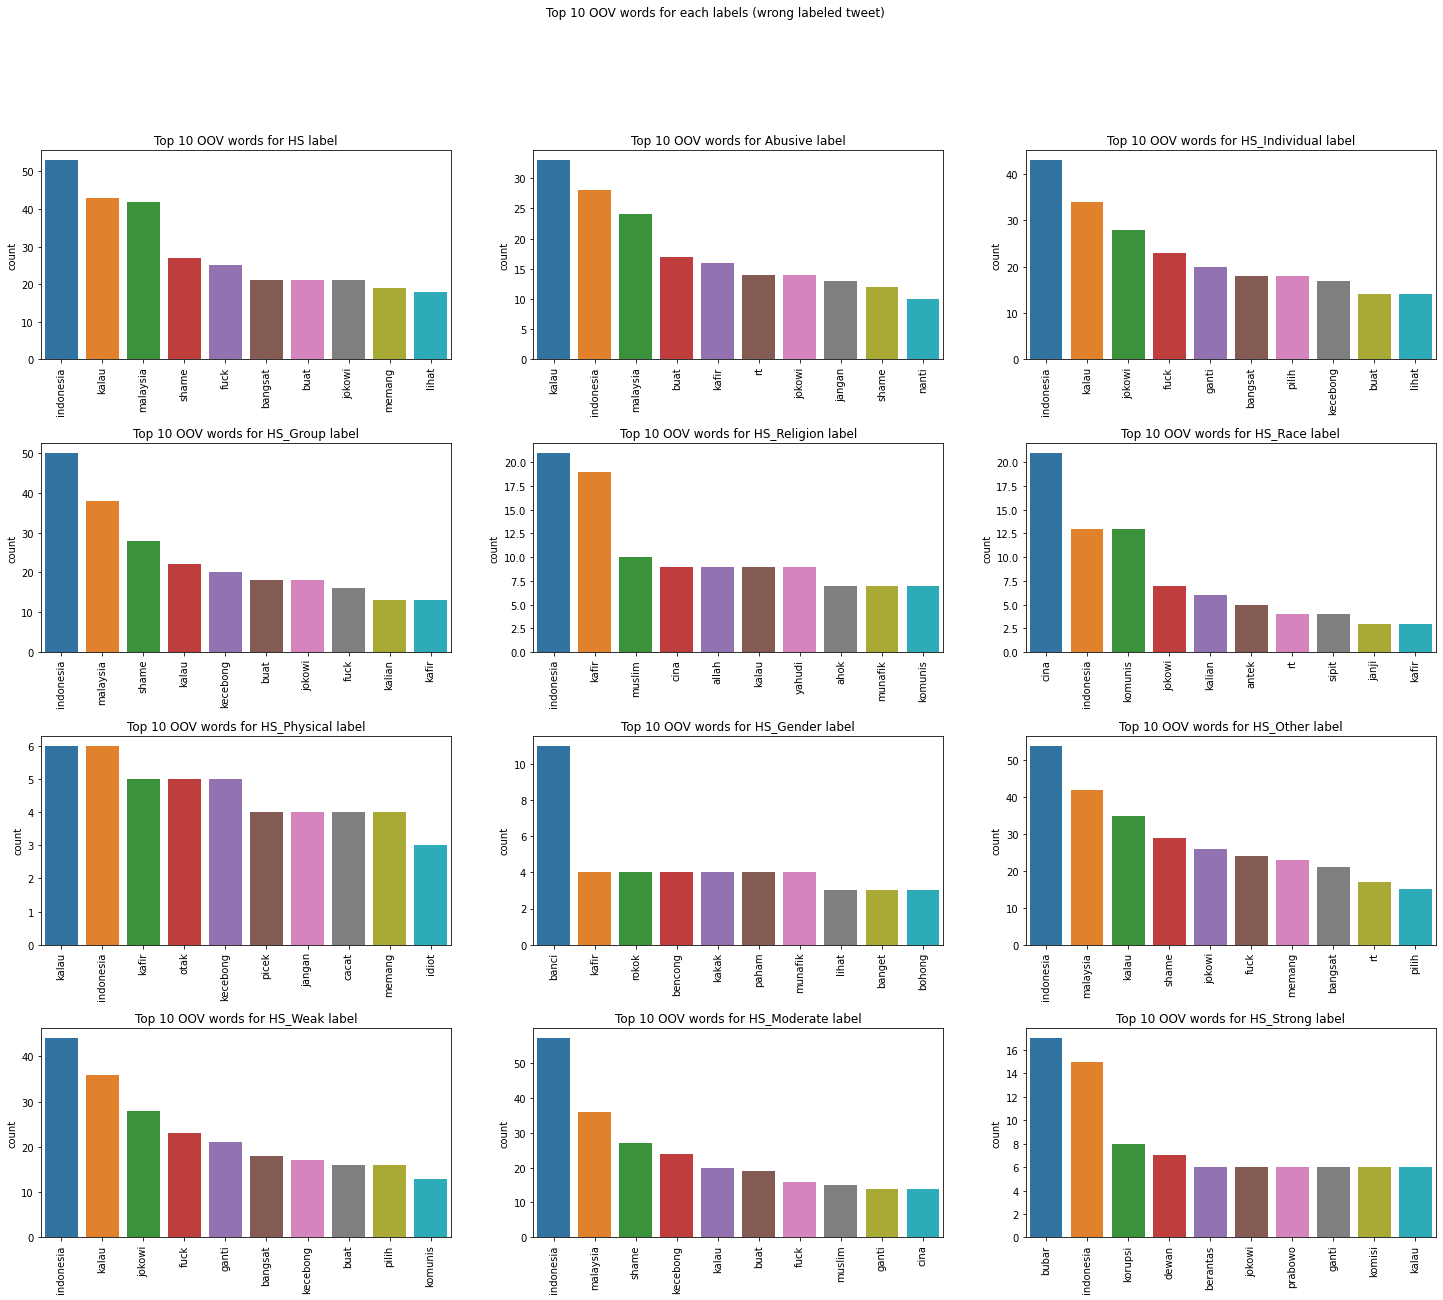

In [44]:

plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_val[join_data_val[target[i]]!=join_data_val[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [45]:
miss_exact_tweet_val['Tweet_Parsed'].values.tolist()

['so much berengsek people in the world',
 'rt user dasar bajing url',
 'rt user tidak ada urus monyet aku break home tidak begitu begitu amat malah pukul sama teman teman aku  kaya raya tidak ada tidak ada h ',
 'rt user  tai  tidak ada  mau join tag close agency basic ',
 ' ampun ini rupiah asing banget kepada ',
 'user user aku lagi celeng tidak buat synna emosi jangan mancing  ',
 'malaysia be defeat infinit  tunggu timnas day shame on you malaysia',
 'user user bacot  kalian ',
 'bahas islam rusak nilai user kuat karakter lalu revitalisasi didik nilai',
 'user kamu kafir banci   ampun sudah kafir banci lagi jangan sedih  cong kamu google  kafir banci kayak kamu ',
 'user user baca lagi hadis  benar syariat puasa asyura akikah bukan karena ittiba ikut ajar yahudi dan adat arab tapi karena para sahabat ittiba sunnah nabi gamis itu hukum mubah seperti sarung peci koko tidak a',
 'sendu gila rasa ',
 'ajar tapi apa the point kamu maksud anjing itu predator ke kucing itu prey i think k

In [46]:
miss_exact_tweet_val.iloc[:,1:-12].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [47]:
miss_exact_tweet_val.iloc[:,-12:].values.tolist()

[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0],
 [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0

## Data Test Predict Analysis

In [0]:
data_test_predict = pd.DataFrame(data=data_test['Tweet'],columns=['Tweet']).reset_index(drop=True).join(pd.DataFrame(data=pred_test, columns=target)).join(pd.DataFrame(data=data_test['Tweet_Parsed'],columns=['Tweet_Parsed']).reset_index(drop=True))

### Check Number of Label on Predict Data

In [0]:
label_size0_test = []
label_size1_test = []

for i in data_test.columns[2:-1]:
    label_size0_test.append(len(data_test[data_test[i]==0]))
    label_size1_test.append(len(data_test[data_test[i]==1]))

label_size0_test_predict = []
label_size1_test_predict = []

for i in data_test_predict.columns[1:-1]:
    label_size0_test_predict.append(len(data_test_predict[data_test_predict[i]==0]))
    label_size1_test_predict.append(len(data_test_predict[data_test_predict[i]==1]))

In [0]:
dat_anls_test = pd.DataFrame({
    'label' : data_test.columns[2:-1],
    'stats' : ["negative" for i in range(len(data_test.columns[2:-1]))],
    'jumlah' : label_size0_test
}).append(
    pd.DataFrame({
        'label' : data_test.columns[2:-1],
        'stats' : ["positive" for i in range(len(data_test.columns[2:-1]))],
        'jumlah' : label_size1_test
    })
)

# dat_anls_test = dat_anls_test.set_index(['label'], drop=True)

dat_anls_test_predict = pd.DataFrame({
    'label' : data_test_predict.columns[1:-1],
    'stats' : ["negative" for i in range(len(data_test_predict.columns[1:-1]))],
    'jumlah' : label_size0_test_predict
}).append(
    pd.DataFrame({
        'label' : data_test_predict.columns[1:-1],
        'stats' : ["positive" for i in range(len(data_test_predict.columns[1:-1]))],
        'jumlah' : label_size1_test_predict
    })
)

# dat_anls_test_predict = dat_anls_test_predict.set_index(['label'], drop=True)

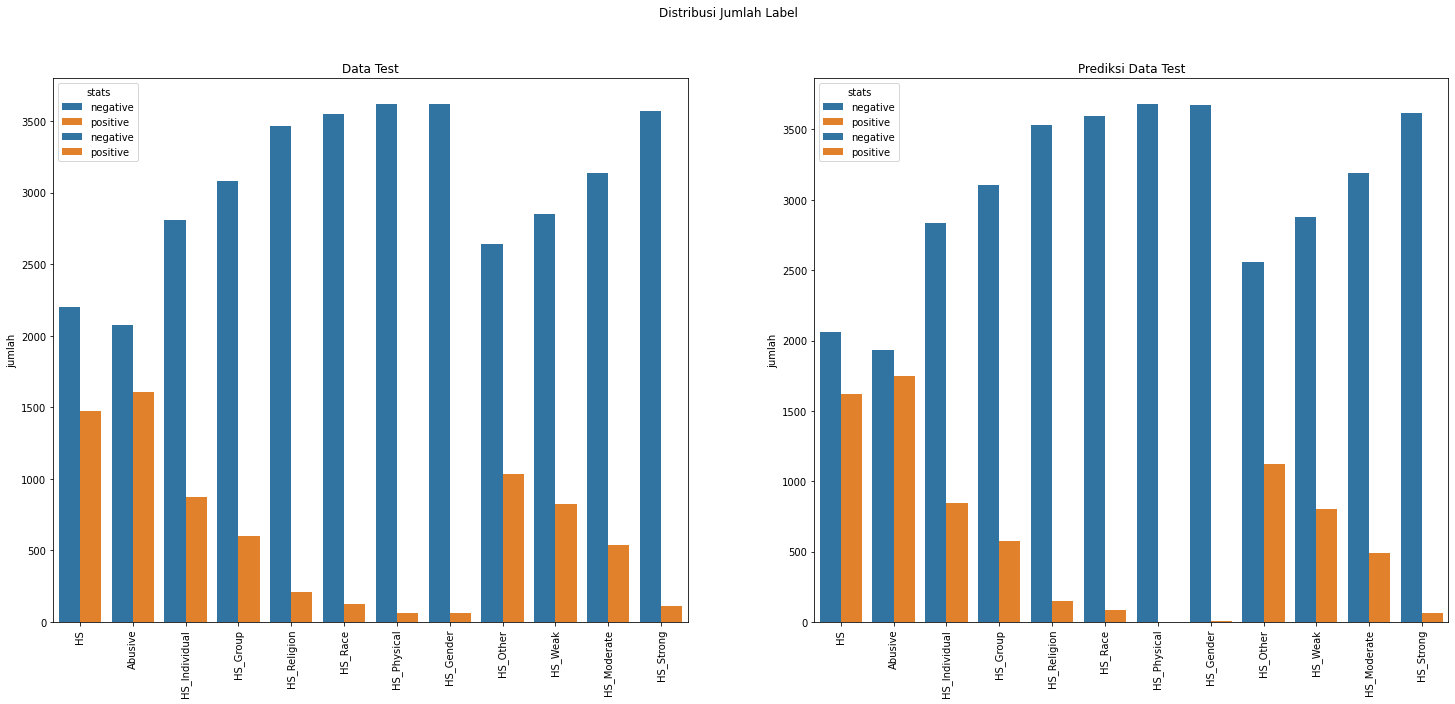

In [51]:
plt.figure(figsize=(25,10))
plt.suptitle('Distribusi Jumlah Label')

plt.subplot(1,2,1)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test).get_xticklabels(),rotation=90)
plt.title("Data Test")
plt.xlabel('')

plt.subplot(1,2,2)
sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).set_xticklabels(sns.barplot(x="label", y="jumlah",hue="stats", data=dat_anls_test_predict).get_xticklabels(),rotation=90)
plt.title("Prediksi Data Test")
plt.xlabel('')

plt.show()

In [52]:
pd.DataFrame({
    "label" : data_test.columns[2:-1],
    "negative (true)" : dat_anls_test[dat_anls_test['stats'] == "negative"]["jumlah"].values,
    "positive (true)" : dat_anls_test[dat_anls_test['stats'] == "positive"]["jumlah"].values,
    "negative (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "negative"]["jumlah"].values,
    "positive (predict)" : dat_anls_test_predict[dat_anls_test_predict['stats'] == "positive"]["jumlah"].values
})

,label,negative (true),positive (true),negative (predict),positive (predict)
0,HS,2204,1476,2063,1617
1,Abusive,2075,1605,1932,1748
2,HS_Individual,2806,874,2836,844
3,HS_Group,3078,602,3106,574
4,HS_Religion,3467,213,3530,150
5,HS_Race,3551,129,3597,83
6,HS_Physical,3617,63,3678,2
7,HS_Gender,3616,64,3671,9
8,HS_Other,2643,1037,2560,1120
9,HS_Weak,2854,826,2879,801


### OOV Check

In [0]:
join_data_test = data_test.join(data_test_predict.drop(['Tweet','Tweet_Parsed'],axis=1),rsuffix="_predict")

In [0]:
miss_exact_tweet_test = join_data_test[(join_data_test["HS"]!=join_data_test["HS_predict"]) | (join_data_test["Abusive"] != join_data_test["Abusive_predict"]) | (join_data_test["HS_Individual"] != join_data_test["HS_Individual_predict"]) | (join_data_test["HS_Group"] != join_data_test["HS_Group_predict"]) | (join_data_test["HS_Religion"] != join_data_test["HS_Religion_predict"]) | (join_data_test["HS_Race"] != join_data_test["HS_Race_predict"]) | (join_data_test["HS_Physical"] != join_data_test["HS_Physical_predict"]) | (join_data_test["HS_Gender"] != join_data_test["HS_Gender_predict"]) | (join_data_test["HS_Other"] != join_data_test["HS_Other_predict"]) | (join_data_test["HS_Weak"] != join_data_test["HS_Weak_predict"]) | (join_data_test["HS_Moderate"] != join_data_test["HS_Moderate_predict"]) | (join_data_test["HS_Strong"] != join_data_test["HS_Strong_predict"])]

In [0]:
oov_test = oov(vocab, generate_ngrams(miss_exact_tweet_test['Tweet_Parsed']))
oov_test_count = oov_count(oov_test)

In [56]:
oov_test_count

{'ganteng': 8,
 'berengsek': 29,
 'buat': 104,
 '': 2749,
 'demokrasi': 12,
 'indonesia': 343,
 'juang': 16,
 'bajing': 30,
 'ajar': 29,
 'garong': 2,
 'kafir': 85,
 'pecun': 8,
 'hobi': 1,
 'zina': 1,
 'jancuk': 10,
 'tabok': 1,
 'iya': 54,
 'jablay': 11,
 'sampah': 21,
 'rt': 124,
 'terima': 24,
 'kasih': 29,
 'najwa': 3,
 'jakarta': 28,
 'lucu': 14,
 'banget': 70,
 'ahok': 61,
 'sambung': 8,
 'tanya': 25,
 'kena': 10,
 'sekak': 1,
 'isu': 18,
 'tadi': 5,
 'cina': 121,
 'tolol': 32,
 'suka': 30,
 'kontol': 24,
 'sayang': 18,
 'hizbut': 45,
 'tahrir': 45,
 'pork': 1,
 'najis': 26,
 'dirty': 6,
 'akin': 1,
 'urine': 2,
 'pikir': 29,
 'temptation': 1,
 'educate': 2,
 'upin': 1,
 'ipin': 1,
 'munafik': 56,
 'muslim': 46,
 'bantai': 5,
 'usir': 31,
 'dear': 13,
 'malaysia': 131,
 'idiot': 19,
 'tortor': 8,
 'punya': 32,
 'miskin': 34,
 'dibudakcintakan': 2,
 'mempan': 1,
 'gila': 44,
 'ngechat': 1,
 'kalau': 155,
 'rupiah': 9,
 'fuck': 101,
 'iseng': 4,
 'jandro': 1,
 'unfollow': 2,
 'cac

In [57]:
print("number of OOV words : ", len(oov_test))
print("number of unique OOV words : ", len(oov_test_count))

number of OOV words :  15561
number of unique OOV words :  3424


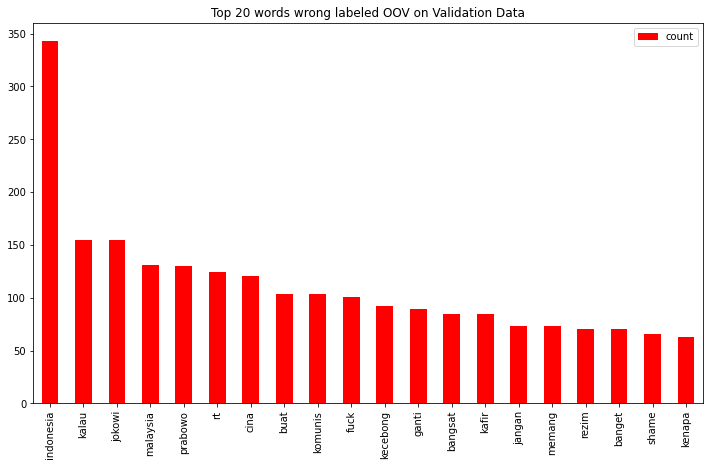

In [58]:
df_oov_test = pd.DataFrame(oov_test_count.items(),columns=["Tweet","count"])
df_oov_test.sort_values(['count'],ascending=False)[1:21].plot(
    kind='bar', y='count',x='Tweet', color='red', title='Top 20 words wrong labeled OOV on Validation Data', figsize=(12,7))
plt.xlabel("")
plt.show()

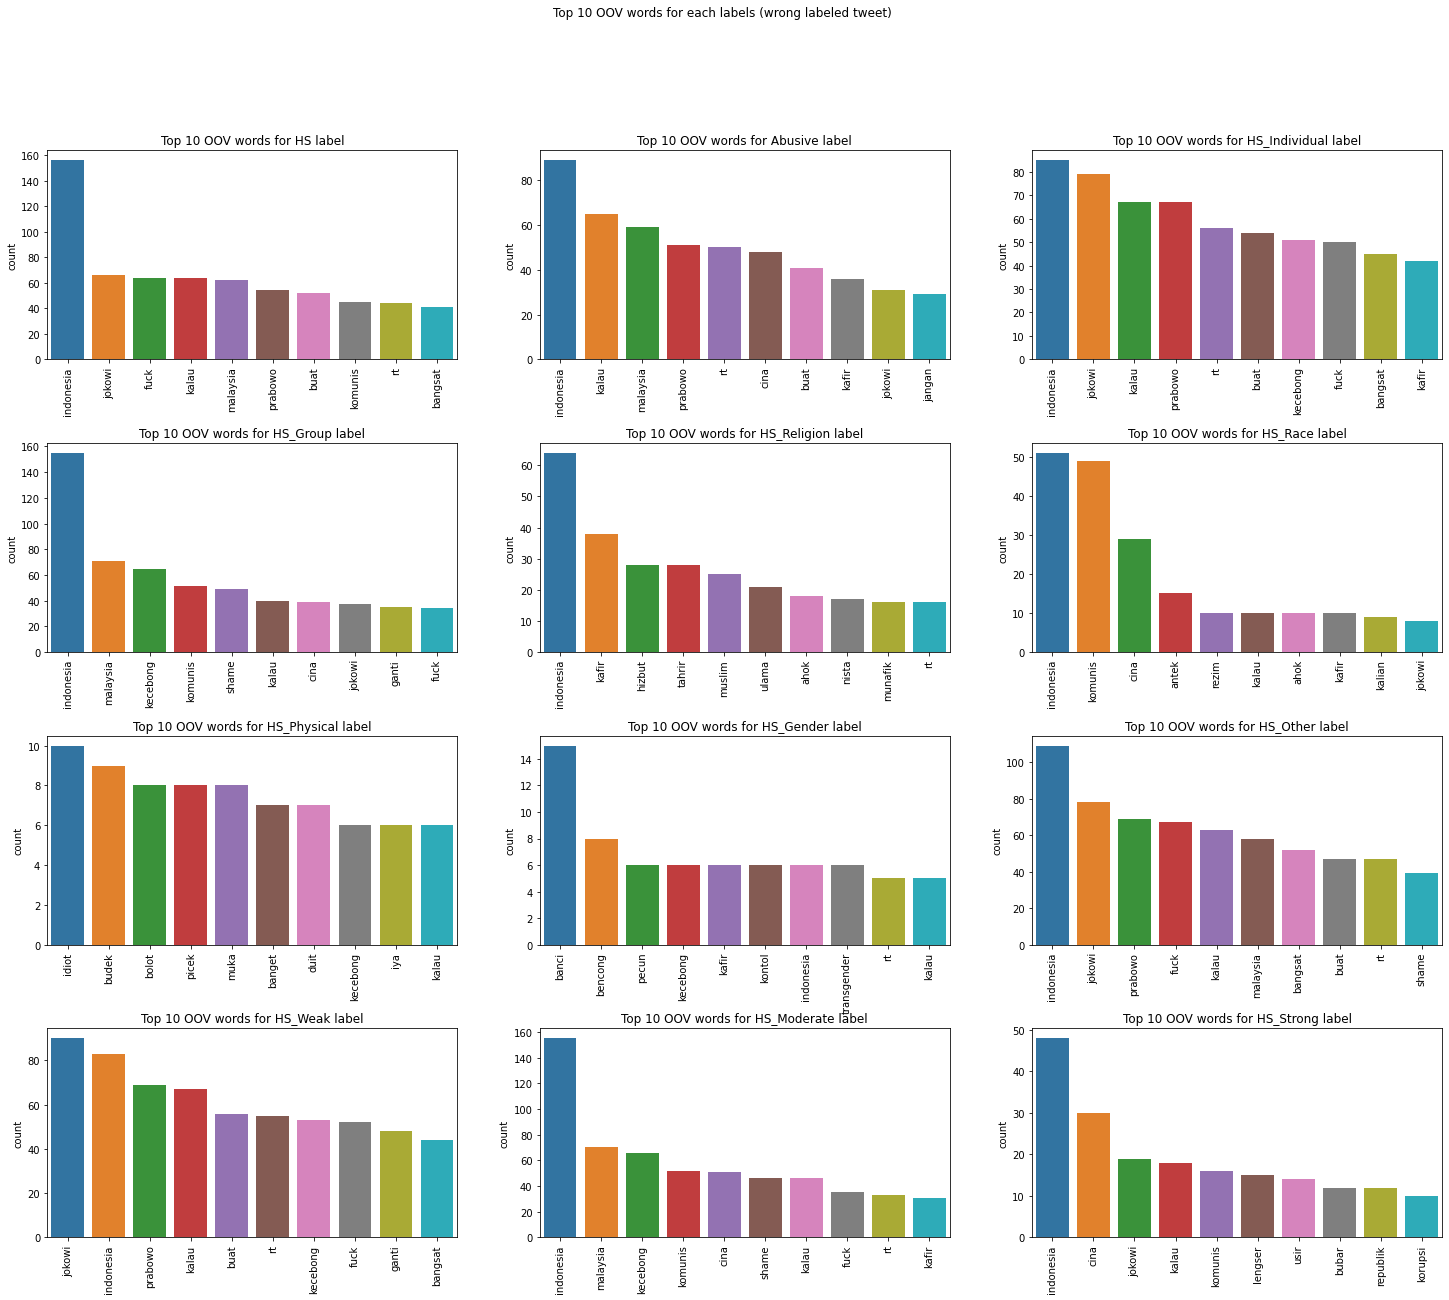

In [59]:
plt.figure(figsize=(25,20))
plt.suptitle('Top 10 OOV words for each labels (wrong labeled tweet)')
for i in range (len(target)):
    plt.subplot(4,3,i+1)
    plt.subplots_adjust(hspace=0.4)
    wrongtweet = join_data_test[join_data_test[target[i]]!=join_data_test[target[i]+str("_predict")]]
    wrongtoken = generate_ngrams(wrongtweet['Tweet_Parsed']).tolist()
    wrong_oov = oov(vocab, wrongtoken)
    wrong_oov_count = oov_count(wrong_oov)
    frame = pd.DataFrame(wrong_oov_count.items(),columns=["Tweet","count"])
    frame = frame.sort_values(['count'],ascending=False)[1:11]
    sns.barplot(x="Tweet", y="count", data=frame).set_xticklabels(sns.barplot(x="Tweet", y="count", data=frame).get_xticklabels(),rotation=90)
    title='Top 10 OOV words for '+str(target[i])+" label"
    plt.title(title)
    plt.xlabel("")

### Tweet Check

In [60]:
miss_exact_tweet_test['Tweet'].values.tolist()

["GANTENG TAPI BERENGSEK!!! BUAT APA?!!\nWHO DO YOU THINK YOU ARE? YOU'RE NOTHING!! TO ME! << REMEMBER THIS!!",
 "USER USER Karena partaimu pdip itu bajingan'",
 "USER Khan yg ngajarin si garong kafir'",
 "USER Anak pecun... ga jauh2 dr hobi zina.. haha'",
 "USER Jancuk! Pingin gue tabok itu anak'",
 'Yg bawah sendiri keren Ã°???',
 "USER USER USER USER USER USER iyain dah tante jablay wkwk'",
 'I like you. You like him, itukan berengsek :3 #nyampah',
 "RT USER: Ya, saya bajingan\\nTERIMA KASIH'",
 '#MataNajwaDebatJakarta lucu banget jawaban ahok.. gak nyambung. Ditanya apa di jawab apa. Kena skak mat d pertanyaan isu agama tdi. Dasar cina tolol hahaha',
 "gw suka kontol lo beb :*'",
 'except being HTI and FPI of course.',
 'No pork is najis or dirty. It is considered akin to drinking urine. At least in sub continent context. So that is the reason it being the final barrier. Other things are more like temptations.',
 "educate your self a lil before saying things like this. Upin Ipin mo

In [61]:
miss_exact_tweet_test['Tweet_Parsed'].values.tolist()

['ganteng tapi berengsek buat apa who do you think you be you re nothing to me remember this ',
 'user user karena partai partai demokrasi indonesia juang itu bajing ',
 'user   ajar  garong kafir ',
 'user anak pecun tidak jauh jauh dari hobi zina  ',
 'user jancuk ingin aku tabok itu anak ',
 ' bawah sendiri keren ',
 'user user user user user user iya sudah tante jablay  ',
 'i like you you like him itu  berengsek sampah',
 'rt user  saya bajing terima kasih ',
 ' mata najwa debat jakarta lucu banget jawab ahok tidak sambung tanya apa di jawab apa kena sekak mat di tanya isu agama tadi dasar cina tolol ',
 'aku suka kontol kamu sayang ',
 'except be hizbut tahrir indonesia and front bela islam of course ',
 'no pork be najis orang dirty it be consider akin to drink urine at least in sub continent context so that be the reason it be the final barrier other pikir be more like temptation ',
 'educate your self a little belum say pikir like this upin ipin film and munafik do so well her

In [62]:
miss_exact_tweet_test.iloc[:,2:-13].columns

Index(['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race',
       'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate',
       'HS_Strong'],
      dtype='object')

In [63]:
# real label
miss_exact_tweet_test.iloc[:,2:-13].values.tolist()

[[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
 [1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0,

In [0]:
miss_exact_tweet_test.to_csv("/content/gdrive/My Drive/Colab Notebooks/Tugas Akhir/bestresult_distilbert_nostopword.csv",index=False,sep=";")